In [29]:
import numpy as np
import yaml

from typing import Dict

import time
import sklearn.preprocessing

from helpers import *

def load_config(file_path: str) -> Dict:
    """Load configuration from a YAML file."""
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#====================================================
def tune_hnsw_hyperparameters(train_data, test_data, dim, k, metric, config_file, brutes_labels):
    """Tune HNSW hyperparameters based on the provided configuration file."""
    config = load_config(config_file)
    results = []

    for _, group in config['float']['any'][0]['run_groups'].items():
        for arg_group in group['arg_groups']:
            M = arg_group['M']
            efConstruction = arg_group['efConstruction']
            print(f"Evaluating M={M}, efConstruction={efConstruction}")

            # Build HNSW index with the current set of hyperparameters
            hnsw_index = hnswlib.Index(space=metric, dim=dim)
            hnsw_index.init_index(max_elements=len(train_data), ef_construction=efConstruction, M=M)
            hnsw_index.add_items(train_data)

            # Querying the index
            labels, distances = run_hnsw(hnsw_index, test_data, k)

            # Calculate recall
            avg_recall = np.mean(recall(labels, brutes_labels))

            results.append({'M': M, 'efConstruction': efConstruction, 'labels': labels, 'recall': avg_recall})

    return results
# ===================================================
class ANNExperiment:
    def __init__(self, dataset_name, k, metric, result_dir):
        self.dataset_name = dataset_name
        self.k = k
        self.metric = metric
        self.result_dir = result_dir
        self.results = {}

        self.train, self.test, self.dim = load_and_transform_dataset(self.dataset_name)
        if self.metric == 'cosine':
            self.train = sklearn.preprocessing.normalize(self.train, axis=1, norm="l2")
            self.test = sklearn.preprocessing.normalize(self.test, axis=1, norm="l2")

        print("Dataset Loaded")
        print("="*21)
        self.filename = dataset_name.split('-')[0]
        
        # brute force ground truth
        print('Running Brute Force')
        start = time.time()
        brute = build_brute(self.train, self.dim, metric='l2')
        brute_build_time = time.time() - start
        print(f'Brute Build Time: {brute_build_time} seconds')

        start = time.time()
        self.brute_labels, self.brute_dist = run_brute(brute, self.test, self.k)
        brute_query_time = time.time() - start
        print(f'Brute Query Time: {brute_query_time} seconds')
        print("="*21)

        self.results['brute'] = {}
        self.results['brute']['build_time'] = brute_build_time
        self.results['brute']['query_time'] = brute_query_time

        brute_export_index(brute, f"brute_index_{self.filename}", self.result_dir)
        export_to_hdf5(self.brute_labels, f"brute_labels_{self.filename}", f"brute_labels_{self.filename}", self.result_dir)
        export_to_hdf5(self.brute_dist, f"brute_dist_{self.filename}", f"brute_dist_{self.filename}", self.result_dir)
        
    def run_experiment(self):

        # hnsw
        print('Running HNSW')
        
        start = time.time()
        hnsw = build_hnsw(self.train, self.dim, metric='l2')
        hnsw_build_time = time.time() - start
        print(f'HNSW Build Time: {hnsw_build_time} seconds')

        start = time.time()
        hnsw_labels, hnsw_dist = run_hnsw(hnsw, self.test, self.k)
        hnsw_query_time = time.time() - start
        print(f'HNSW Query Time: {hnsw_query_time} seconds')

        hnsw_recall = np.mean(recall(hnsw_labels, self.brute_labels))
        print(f'HNSW Recall: {hnsw_recall}')
        print("="*21)

        self.results['hnsw'] = {}
        self.results['hnsw']['recall'] = hnsw_recall
        self.results['hnsw']['build_time'] = hnsw_build_time
        self.results['hnsw']['query_time'] = hnsw_query_time

        hnsw_export_index(hnsw, f"hnsw_index_{self.filename}", self.result_dir)
        export_to_hdf5(hnsw_labels, f"hnsw_labels_{self.filename}", f"hnsw_labels_{self.filename}", self.result_dir)
        export_to_hdf5(hnsw_dist, f"hnsw_dist_{self.filename}", f"hnsw_dist_{self.filename}", self.result_dir)

    # tune hyperparameters for HNSW
    def tune_hnsw(self, config_file):
        self.hnsw_results = tune_hnsw_hyperparameters(self.train, self.test, self.dim, self.k, self.metric, config_file, self.brute_labels)
        self.hnsw_results.sort(key=lambda x: x['recall'], reverse=True)
        print(self.hnsw_results)

In [ ]:
all_data_result_dict = {}

In [38]:
dataset_name = 'sift-128-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already

exp = ANNExperiment(dataset_name, k, metric)
exp.run_experiment()

# get accuracy results
all_data_result_dict['sift'] = exp.results
exp.results

Got a train set of size (1000000 * 128)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.7980024814605713 seconds
Brute Query Time: 424.631534576416 seconds
Running HNSW
HNSW Build Time: 138.07196140289307 seconds
HNSW Query Time: 0.1510026454925537 seconds
HNSW Recall: 0.7089700000000001


{'brute': {'build_time': 0.7980024814605713, 'query_time': 424.631534576416},
 'hnsw': {'recall': 0.7089700000000001,
  'build_time': 138.07196140289307,
  'query_time': 0.1510026454925537}}

In [39]:
exp.tune_hnsw(config_file='config.yml')
print(exp.hnsw_results)

Evaluating M=12, efConstruction=500
Evaluating M=16, efConstruction=500
Evaluating M=24, efConstruction=500
Evaluating M=36, efConstruction=500
Evaluating M=4, efConstruction=500
Evaluating M=48, efConstruction=500
Evaluating M=64, efConstruction=500
Evaluating M=8, efConstruction=500
Evaluating M=96, efConstruction=500
[{'M': 96, 'efConstruction': 500, 'labels': array([[932085, 934876, 695756, ..., 562594, 908244, 600499],
       [413247, 413071, 249062, ..., 271353, 987215, 832927],
       [669835, 408764, 408462, ..., 406324, 551743, 861530],
       ...,
       [123855, 123351, 534149, ..., 489622, 501086, 899050],
       [755327, 755323, 840765, ..., 893250, 825100, 980141],
       [874343, 413340, 315476, ..., 500368, 582737,  76770]],
      dtype=uint64), 'recall': 0.8238700000000001}, {'M': 64, 'efConstruction': 500, 'labels': array([[708177, 706771, 701258, ..., 908244, 600499, 619660],
       [413247, 413071, 249062, ..., 849742, 192537, 271353],
       [669835, 408764, 408462

In [34]:
dataset_name = 'glove-100-angular'
k = 10
metric = 'cosine' # l2 or cosine

exp = ANNExperiment(dataset_name, k, metric)
exp.run_experiment()

# get accuracy results
all_data_result_dict['glove'] = exp.results
exp.results

Got a train set of size (1183514 * 100)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.6722877025604248 seconds
Brute Query Time: 488.3572566509247 seconds
Running HNSW
HNSW Build Time: 255.88850927352905 seconds
HNSW Query Time: 0.2036600112915039 seconds
HNSW Recall: 0.47152


{'brute': {'build_time': 0.6722877025604248, 'query_time': 488.3572566509247},
 'hnsw': {'recall': 0.47152,
  'build_time': 255.88850927352905,
  'query_time': 0.2036600112915039}}

In [35]:
exp.tune_hnsw(config_file='config.yml')
print(exp.hnsw_results)

Evaluating M=12, efConstruction=500
Evaluating M=16, efConstruction=500
Evaluating M=24, efConstruction=500
Evaluating M=36, efConstruction=500
Evaluating M=4, efConstruction=500
Evaluating M=48, efConstruction=500
Evaluating M=64, efConstruction=500
Evaluating M=8, efConstruction=500
Evaluating M=96, efConstruction=500
[{'M': 96, 'efConstruction': 500, 'labels': array([[ 846101,  723915,  660281, ...,  994865,  331310,  859959],
       [ 875925,  903728,  144313, ...,  891287,  671097,  188917],
       [1046944,  809599,  323299, ...,  569199,  237710,  859701],
       ...,
       [1108312,  330498,  945288, ...,  350756, 1180096,  196396],
       [ 214774, 1114909,  712717, ...,  139365,  587951,  988960],
       [ 423309,  484674, 1139759, ..., 1057752,  299269,  841659]],
      dtype=uint64), 'recall': 0.66629}, {'M': 64, 'efConstruction': 500, 'labels': array([[ 846101,  723915,  656605, ...,  331310,  368655, 1168162],
       [ 875925,  903728,  144313, ..., 1081448,  144140,  13

In [40]:
dataset_name = 'deep-image-96-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already

exp = ANNExperiment(dataset_name, k, metric)
exp.run_experiment()

# get accuracy results
all_data_result_dict['deep'] = exp.results
exp.results

Got a train set of size (1000000 * 96)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.43900012969970703 seconds
Brute Query Time: 299.9161820411682 seconds
Running HNSW
HNSW Build Time: 121.02939939498901 seconds
HNSW Query Time: 0.12634944915771484 seconds
HNSW Recall: 0.7033400000000001


{'brute': {'build_time': 0.43900012969970703, 'query_time': 299.9161820411682},
 'hnsw': {'recall': 0.7033400000000001,
  'build_time': 121.02939939498901,
  'query_time': 0.12634944915771484}}

In [41]:
exp.tune_hnsw(config_file='config.yml')
print(exp.hnsw_results)

Evaluating M=12, efConstruction=500
Evaluating M=16, efConstruction=500
Evaluating M=24, efConstruction=500
Evaluating M=36, efConstruction=500
Evaluating M=4, efConstruction=500
Evaluating M=48, efConstruction=500
Evaluating M=64, efConstruction=500
Evaluating M=8, efConstruction=500
Evaluating M=96, efConstruction=500
[{'M': 96, 'efConstruction': 500, 'labels': array([[876396, 154930, 858837, ..., 379073, 807129, 713272],
       [924383, 193037, 731076, ..., 245627, 682528, 452910],
       [435654, 670539, 479529, ..., 485354, 873895, 596161],
       ...,
       [410443, 652624, 277683, ..., 804869, 551907, 799447],
       [668539, 484487,  33753, ..., 120879, 765160, 462862],
       [236347, 656479, 670403, ..., 666707, 171414, 703745]],
      dtype=uint64), 'recall': 0.8245800000000001}, {'M': 64, 'efConstruction': 500, 'labels': array([[876396, 154930, 858837, ..., 379073, 807129, 713272],
       [924383, 193037, 731076, ..., 245627, 682528, 452910],
       [435654, 670539, 479529

In [31]:
dataset_name = 'mnist-784-euclidean'
k = 10
metric = 'l2' # l2 or angular --> for annoy have condition to change the name already

exp = ANNExperiment(dataset_name, k, metric)
exp.run_experiment()

# get accuracy results
all_data_result_dict['mnist'] = exp.results
exp.results

Got a train set of size (60000 * 784)
Got 10000 queries
Dataset Loaded
Running Brute Force
Brute Build Time: 0.09443473815917969 seconds
Brute Query Time: 211.25127291679382 seconds
Running HNSW
HNSW Build Time: 19.016373872756958 seconds
HNSW Query Time: 0.4783315658569336 seconds
HNSW Recall: 0.9284100000000002


{'brute': {'build_time': 0.09443473815917969,
  'query_time': 211.25127291679382},
 'hnsw': {'recall': 0.9284100000000002,
  'build_time': 19.016373872756958,
  'query_time': 0.4783315658569336}}

In [32]:
exp.tune_hnsw(config_file='config.yml')
print(exp.hnsw_results)

Evaluating M=12, efConstruction=500
Evaluating M=16, efConstruction=500
Evaluating M=24, efConstruction=500
Evaluating M=36, efConstruction=500
Evaluating M=4, efConstruction=500
Evaluating M=48, efConstruction=500
Evaluating M=64, efConstruction=500
Evaluating M=8, efConstruction=500
Evaluating M=96, efConstruction=500
[{'M': 64, 'efConstruction': 500, 'labels': array([[53843, 38620, 16186, ..., 15260, 40368, 36395],
       [28882, 49160, 24612, ..., 24010, 21012, 53455],
       [58741, 46512, 15224, ..., 53361, 12578, 27684],
       ...,
       [ 3261, 58994, 35362, ..., 50284,  2003,  8220],
       [36407,  1311,  6011, ..., 17217, 33321, 43508],
       [22424,  5179,  5329, ..., 52441, 10767, 49405]], dtype=uint64), 'recall': 0.94755}, {'M': 48, 'efConstruction': 500, 'labels': array([[53843, 38620, 16186, ..., 40368, 36395, 30502],
       [28882, 49160, 24612, ..., 24010, 21012, 53455],
       [58741, 46512, 15224, ..., 53361, 12578, 27684],
       ...,
       [ 3261, 58994, 35362

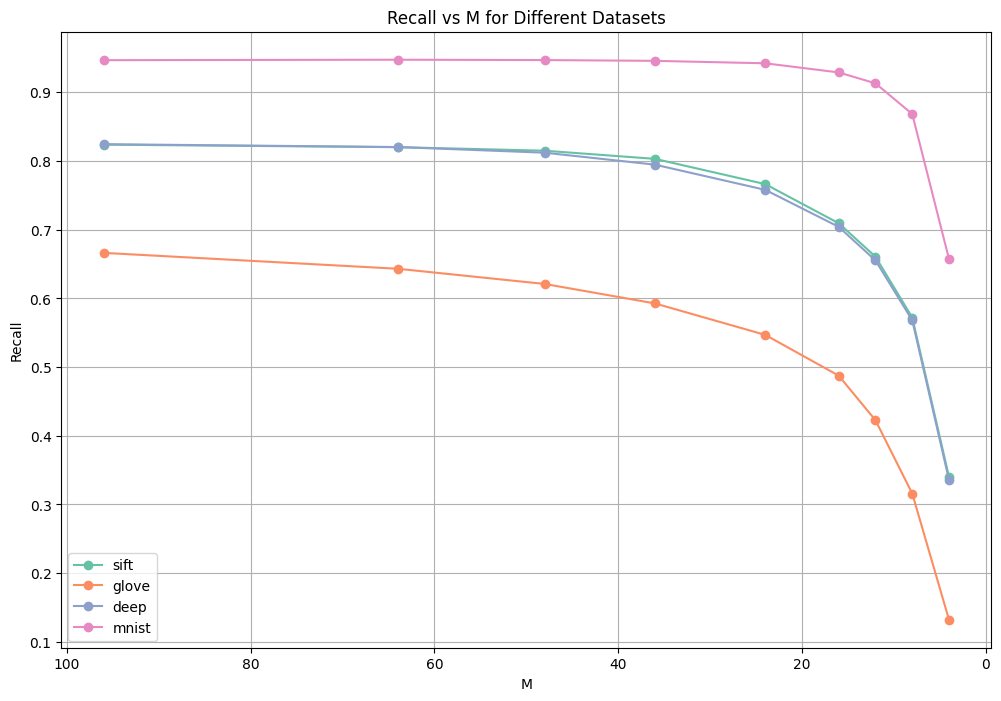

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for each dataset
datasets = {
    "sift": {
        "Ms": [96, 64, 48, 36, 24, 16, 12, 8, 4],
        "recalls": [0.82387, 0.82022, 0.81505, 0.80319, 0.76642, 0.7094, 0.66068, 0.57209, 0.33992]
    },
    "glove": {
        "Ms": [96, 64, 48, 36, 24, 16, 12, 8, 4],
        "recalls": [0.66629, 0.64316, 0.62103, 0.59268, 0.54688, 0.48748, 0.42252, 0.31581, 0.13207]
    },
    "deep": {
        "Ms": [96, 64, 48, 36, 24, 16, 12, 8, 4],
        "recalls": [0.82458, 0.82039, 0.81217, 0.79475, 0.75808, 0.70417, 0.65526, 0.56818, 0.33575]
    },
    "mnist": {
        "Ms": [96, 64, 48, 36, 24, 16, 12, 8, 4],
        "recalls": [0.9469, 0.94755, 0.94705, 0.94591, 0.94235, 0.92906, 0.91315, 0.86844, 0.65731]
    }
}

# Plotting
colors = sns.color_palette("Set2")

plt.figure(figsize=(12, 8))

for i, (dataset_name, data) in enumerate(datasets.items()):
    plt.plot(data["Ms"], data["recalls"], marker='o', color=colors[i], label=dataset_name)

plt.xlabel('M')
plt.ylabel('Recall')
plt.title('Recall vs M for Different Datasets')
plt.legend()
plt.gca().invert_xaxis()  # Invert the x-axis to show decreasing values of M
plt.grid(True)
plt.show()

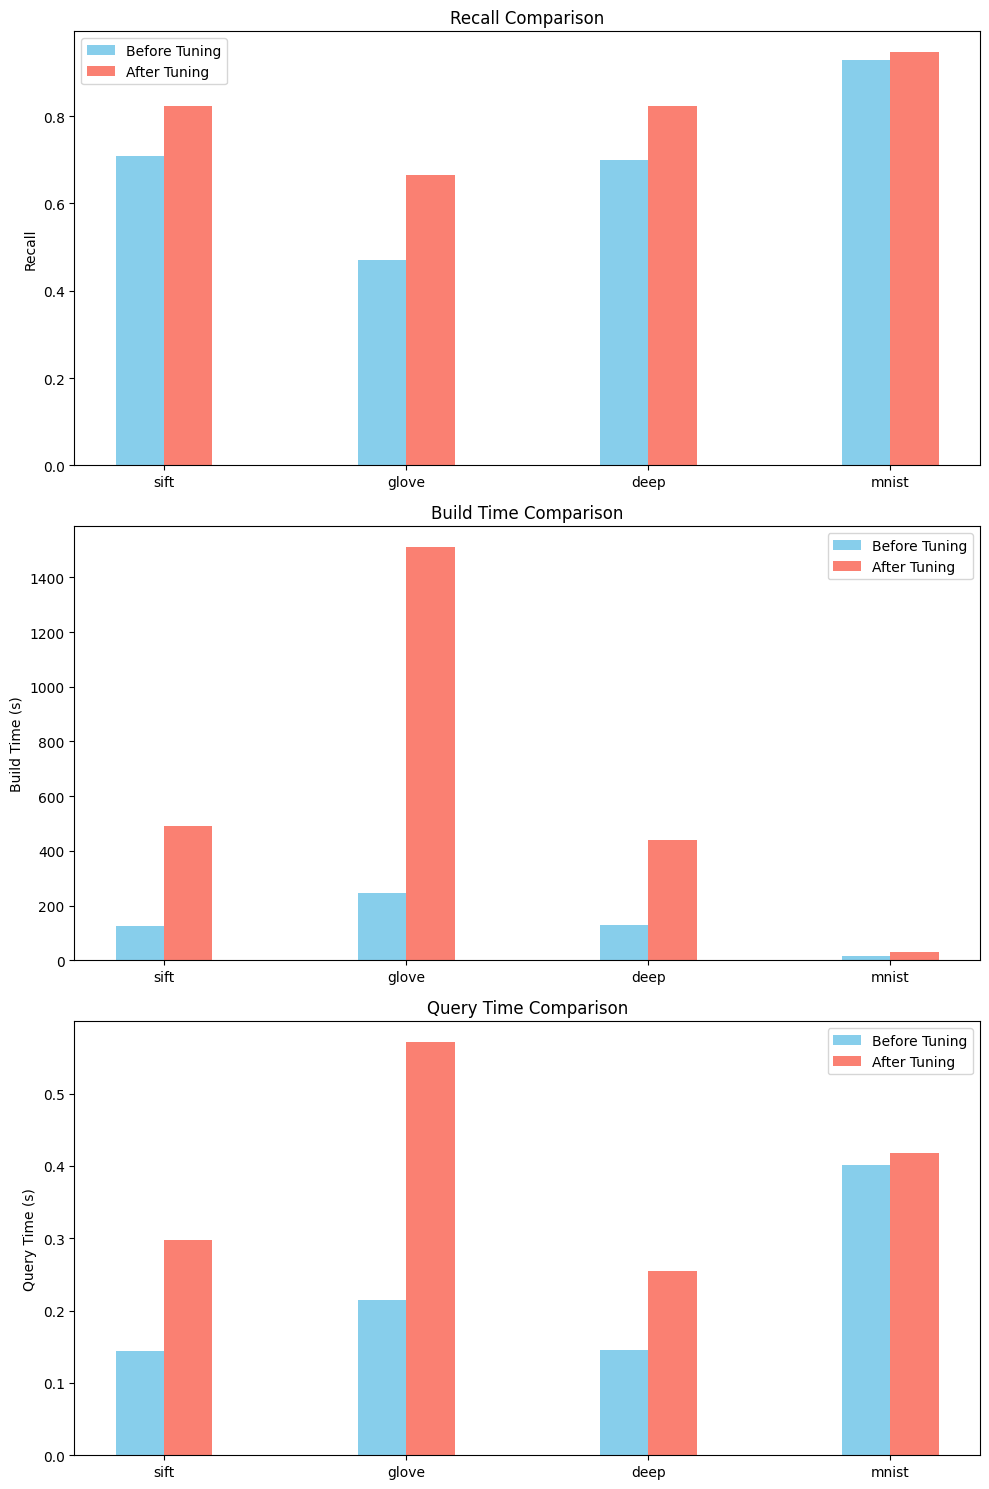

In [1]:
import matplotlib.pyplot as plt
import numpy as np

data_before_tuning = {
    'sift': {'recall': 0.70828, 'build_time': 123.6417624950409, 'query_time': 0.14356136322021484},
    'glove': {'recall': 0.4706, 'build_time': 246.98338413238525, 'query_time': 0.2142331600189209},
    'deep': {'recall': 0.7000700000000001, 'build_time': 130.78997421264648, 'query_time': 0.1455221176147461},
    'mnist': {'recall': 0.92871, 'build_time': 17.066320657730103, 'query_time': 0.40122151374816895}
}

data_after_tuning = {
    'sift': {'recall': 0.8235299999999999, 'build_time': 490.23624992370605, 'query_time': 0.29738807678222656},
    'glove': {'recall': 0.66635, 'build_time': 1511.0596585273743, 'query_time': 0.5713100433349609},
    'deep': {'recall': 0.8231200000000001, 'build_time': 440.2416741847992, 'query_time': 0.2549624443054199},
    'mnist': {'recall': 0.9471800000000001, 'build_time': 31.10383129119873, 'query_time': 0.41745567321777344}
}

datasets = list(data_before_tuning.keys())

# Extracting data for plotting
recall_before = [data_before_tuning[dataset]['recall'] for dataset in datasets]
recall_after = [data_after_tuning[dataset]['recall'] for dataset in datasets]

build_time_before = [data_before_tuning[dataset]['build_time'] for dataset in datasets]
build_time_after = [data_after_tuning[dataset]['build_time'] for dataset in datasets]

query_time_before = [data_before_tuning[dataset]['query_time'] for dataset in datasets]
query_time_after = [data_after_tuning[dataset]['query_time'] for dataset in datasets]

# Setting the positions and width for the bars
pos = np.arange(len(datasets))
bar_width = 0.2

# Colors
colors_before = 'skyblue'
colors_after = 'salmon'

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Recall
ax[0].bar(pos - bar_width/2, recall_before, bar_width, label='Before Tuning', color=colors_before)
ax[0].bar(pos + bar_width/2, recall_after, bar_width, label='After Tuning', color=colors_after)
ax[0].set_title('Recall Comparison')
ax[0].set_xticks(pos)
ax[0].set_xticklabels(datasets)
ax[0].set_ylabel('Recall')
ax[0].legend()

# Build Time
ax[1].bar(pos - bar_width/2, build_time_before, bar_width, label='Before Tuning', color=colors_before)
ax[1].bar(pos + bar_width/2, build_time_after, bar_width, label='After Tuning', color=colors_after)
ax[1].set_title('Build Time Comparison')
ax[1].set_xticks(pos)
ax[1].set_xticklabels(datasets)
ax[1].set_ylabel('Build Time (s)')
ax[1].legend()

# Query Time
ax[2].bar(pos - bar_width/2, query_time_before, bar_width, label='Before Tuning', color=colors_before)
ax[2].bar(pos + bar_width/2, query_time_after, bar_width, label='After Tuning', color=colors_after)
ax[2].set_title('Query Time Comparison')
ax[2].set_xticks(pos)
ax[2].set_xticklabels(datasets)
ax[2].set_ylabel('Query Time (s)')
ax[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()